**Atenção: Devido a natureza dos dados, para correto funcionamento, este notebook precisa ser executado em ambiente com memória RAM maior ou igual a 25 Gb.**

#**Ciência e Visualização de Dados**
##**Projeto Final - Entrega 03**
###Alunos: 
###Gleyson Roberto do Nascimento. RA: 043801. Elétrica.
###Negli René Gallardo Alvarado. RA: 234066. Saúde.
###Rafael Vinícius da Silveira. RA: 137382. Física.
###Sérgio Sevileanu. RA: 941095. Elétrica.



##Neste notebook do Google Colaboratory será realzada a aprendizagem de máquina para os dados do Estado do Paraná durante os anos de 2008 a 2018 segundo o banco de dados [SIHSUS](https://bigdata-metadados.icict.fiocruz.br/dataset/sistema-de-informacoes-hospitalares-do-sus-sihsus/resource/ae85ac54-6734-43b8-a820-6129a854e1ff).

##Desta forma, algumas definições iniciais e um disclaimer se fazem necessários para este projeto:

##Será definido como **diagnóstico equivocado (categoria 0 da variável v258)** aquele em que houve mais de um diagnóstico de CID10, contudo, eles fazem parte do mesmo grupo, de forma que é plausível o equívoco dada a semelhança de sintomas entre os CID10;
##Será definido como **falha de diagnóstico (categoria 1 da variável v258)** aquele em que houve mais de um diagnóstico de CID10, contudo, eles fazem parte de grupos distintos, de forma que embora possam existir sintomas semelhantes entre os CID10, caberia ao profissional uma análise mais aprofundada antes do diagnóstico.
##O **diagnóstico correto** (aquele em que houve apenas um diagnóstico de CID10, sem alterações durante o período até a alta) foi suprimido da análise devido ao fato de que evisiesava  resultados dado o altíssimo percentual de ocorrência; 
##**Disclaimer**: Considerando a natureza do banco de dados do SIHSUS, isto é, um Big Data em que inúmeros funcionários do Sistema Único de Saúde possuem acesso e inserem os dados de forma manual em realdades e condições bastante distintas, existe a séria possibildade de erro sistemático, desta forma, a acurácia deste trabalho deve ser considerada com ressalvas.

#Instalando o RAPIDS no Google Colab

##Verificando se há GPU disponível

In [ ]:
!nvidia-smi

Wed Jun 23 18:26:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Setup:
Set up script installs
1. Updates gcc in Colab
1. Installs Conda
1. Install RAPIDS' current stable version of its libraries, as well as some external libraries including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. BlazingSQL
  1. xgboost
1. Copy RAPIDS .so files into current working directory, a neccessary workaround for RAPIDS+Colab integration.


In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 272 (delta 56), reused 38 (delta 19), pack-reused 171
Receiving objects: 100% (272/272), 79.66 KiB | 7.24 MiB/s, done.
Resolving deltas: 100% (118/118), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla P100-PCIE-16GB!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:9 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu bionic InRelease [20.8 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:29
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL, 
!python rapidsai-csp-utils/colab/install_rapids.py stable

Installing RAPIDS Stable 21.06
Starting the RAPIDS+BlazingSQL install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.0
    - gcsfs
    - llvmlite
    - openssl
    - python=3.7
    - rapids-blazing=21.06


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20210324.1      |       h9c3ff4c_0        1015 KB  conda-forge
    aiohttp-3.7.4.post0        |   py37h5e8e339_0         625 KB  conda-forge
    anyio-3.2.0                |   py37h89c1867_0         138 KB  conda-forge
    appdirs-1.4.4              |     pyh9f0ad1d_0      

#Instalando as Bibliotecas Necessárias

In [ ]:
%matplotlib inline
%load_ext google.colab.data_table
import matplotlib.pyplot as plt
import numpy as np
import gc
import pandas as pd
import pickle
import dask
import dask_cudf
import cudf
from datetime import datetime
from dask import dataframe as dd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
pd.set_option('display.max_columns', None)
pd.options.display.precision = 2
pd.options.display.max_rows = 50
import seaborn as sns
import missingno as msno
import matplotlib as mpl
from matplotlib import rcParams
from numba import jit, njit
mpl.rc('figure', max_open_warning = 0)
from sklearn import preprocessing

#Criando um Client para o Dask

In [ ]:
from dask.distributed import Client,wait
client = Client()
#client = Client(n_workers=2, threads_per_worker=4)
client.cluster

/usr/local/lib/python3.7/site-packages/distributed/client.py:1148: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.19.5 | 1.19.5    | 1.21.0  |
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


#Fazendo autenticação no Google, importando os arquivos através do Google Drive e criando Dask dataframes com limpeza de RAM (garbage collect).

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
ids = ['1Oyd1VdQo3fHJD5LGXNgi5kZBS812MiKN','183SF0fxXbTVXYfko-BOyuwAB2BmZQAmK']
estados = ['BR','BRPRO']
arquivo = ['brasil.pkl','brasilprocessed.pkl']

In [ ]:
dflist=[]
for i in range (len(ids)):
  fileDownloaded = drive.CreateFile({'id':ids[i]})
  fileDownloaded.GetContentFile(arquivo[i])
  globals()[estados[i]] = dd.from_pandas(pd.read_pickle(arquivo[i]),npartitions=245)
  n=gc.collect()
  globals()[estados[i]] = (globals()[estados[i]]).reset_index(drop=True)
  n=gc.collect()
  dflist.append(eval(estados[i]))
  n=gc.collect()

In [ ]:
dflist[0].head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v19,v20,v21,v22,v23,v27,v28,v29,v30,v31,v32,v33,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v54,v55,v56,v57,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v72,v73,v76,v77,v78,v79,v80,v82,v83,v85,v87,v88,v89,v90,v91,v92,v93,v94,v96,v97,v98,v100,v101,v104,v105,v106,v107,v108,v109,v112,v113,v114,v115,v116,v117,v118,v121,v122,v123,v124,v125,v126,v127,v128,v137,v138,v139,v141,v143,v145,v147,v149,v151,v153,v155,v156,v157,v158,v159,v160,v161,v162,v163,v164,v165,v166,v167,v168,v169,v170,v171,v172,v173,v174,v175,v176,v177,v178,v179,v180,v181,v182,v183,v184,v185,v186,v187,v188,v189,v192,v193,v194,v195,v196,v197,v198,v199,v200,v201,v202,v203,v204,v205,v206,v207,v208,v209,v210,v211,v212,v213,v215,v216,v218,v219,v220,v221,v222,v223,v224,v225,v226,v227,v228,v229,v230,v231,v232,v234,v235,v237,v238,v239,v241,v242,v243,v244,v245,v246,v247,v248,v249,v250,v261,v251,v252,v260,v262,v253,v254,v255,v256,v257,v258,v259
0,120000,2008,12,2,5.29e+11,1208100502730,AIH normal,1208100502730,1,Normal,69900100,120040,12,19791012,3,Feminino,0,0,0,0,Não utilizou UTI,0,0,5,411010026,411010026,700.79,447.15,1147.94,0.0,496.94,20081206,20081211,O324,O630,17,Alta da mãe/puérpera e do recém-nascido,61,NaN,NaN,2,Estadual plena,1,Sim,120040,12,4,Anos,29,5,5,0,Sem óbito,10,2,2,2,2,0,Sem filhos/Não inform,0,NaN,0,0,1,Sim,1208103541,0,Seqüencial zerado,0,0,0,NaN,1,21706700172,2002078,5.29e+11,NaN,NaN,2,Média complexidade,6,Média e Alta Complexidade (MAC),0,Sem regra contratual,3,Parda,NaN,3046,HE12000001N200812.DTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153.0,9222.58,120040,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153,9222.58,120040,AC,12,ACRE,AC,ACRE,Região Norte,Região Norte,Acre,AC,Acre,AC,Rio Branco,Rio Branco,NaN,NaN,Baixo Acre e Purus,Baixo Acre e Purus,Rio Branco,Rio Branco,Vale do Acre,Vale do Acre,Rio Branco,Acre,Acre,Região não definida - AC,Região não definida - AC,NaN,Brasil,Não Informado,Obstétricos,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,29,15-49a,25-34a,25-29a,Capítulo XV - Gravidez; parto e puerpério,Assistência prestada à mãe por motivos ligados...,Assistência prestada à mãe por motivo de apres...,Assistência prestada à mãe por polo cefálico a...,NaN,NaN,NaN,NaN,2008,sab,2008,qui,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,O32,O63,NaN,NaN,NaN,Falha de Diagnóstico,Não houve óbito
1,120000,2008,12,2,5.29e+11,1208100502774,AIH normal,1208100502774,1,Normal,69900970,120040,12,19760827,3,Feminino,0,0,0,0,Não utilizou UTI,0,0,3,411010026,411010026,700.79,447.15,1147.94,0.0,496.94,20081209,20081212,O410,O48,17,Alta da mãe/puérpera e do recém-nascido,61,NaN,NaN,2,Estadual plena,1,Sim,120040,12,4,Anos,32,3,3,0,Sem óbito,10,2,2,0,Não,0,Sem filhos/Não inform,0,NaN,0,0,1,Sim,1208103511,0,Seqüencial zerado,0,0,0,NaN,0,0,2002078,5.29e+11,NaN,NaN,2,Média complexidade,6,Média e Alta Complexidade (MAC),0,Sem regra contratual,3,Parda,NaN,3050,HE12000001N200812.DTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153.0,9222.58,120040,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153,9222.58,120040,AC,12,ACRE,AC,ACRE,Região Norte,Região Norte,Acre,AC,Acre,AC,Rio Branco,Rio Branco,NaN,NaN,Baixo Acre e Purus,Baixo Acre e Purus,Rio Branco,Rio Branco,Vale do Acre,Vale do Acre,Rio Branco,Acre,Acre,Região não definida - AC,Região não definida - AC,NaN,Brasil,Não Informado,Obstétricos,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,32,15-49a,25-34a,30-34a,Capítulo XV - Gravidez; parto e puerpério,Assistência prestada à mãe por motivos ligados...,Outros transtornos das membranas e do líquido ...,Oligohidrâmnio,NaN,NaN,NaN,NaN,2008,ter,2008,sex,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.

#Fazendo a Aprendizem de Máquina com Computação Paralela.

##Instalando o Dask Machine Learning.

In [ ]:
!pip install dask-ml

     |████████████████████████████████| 143 kB 14.1 MB/s 


##Instalando as Bibliotecas Necessárias do Sklearn 

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import joblib
from dask_ml.model_selection import train_test_split
import warnings

##Ajustando os dados para tratamento por Machine Learning

In [ ]:
t1 = (dflist[1]).drop(['v49','v82','v104','v105','v225','v226','v227','v228','v229','v230','v231','v232','v253','v254','v255','v256','v257'], axis=1)
n=gc.collect()

In [ ]:
t1 = t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259','v258']]
n=gc.collect()
t1 = t1.loc[t1['v0'].between(410000, 413000,inclusive=True)]
t1.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v19,v20,v21,v22,v23,v27,v28,v29,v30,v31,v32,v33,v43,v44,v45,v46,v47,v48,v50,v51,v52,v54,v55,v56,v57,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v72,v73,v76,v77,v78,v79,v80,v83,v85,v87,v88,v89,v90,v91,v92,v93,v94,v96,v97,v98,v100,v101,v106,v107,v108,v109,v112,v113,v114,v115,v116,v117,v118,v121,v122,v123,v124,v125,v126,v127,v128,v137,v138,v139,v141,v143,v145,v147,v149,v151,v153,v155,v156,v157,v158,v159,v160,v161,v162,v163,v164,v165,v166,v167,v168,v169,v170,v171,v172,v173,v174,v175,v176,v177,v178,v179,v180,v181,v182,v183,v184,v185,v186,v187,v188,v189,v192,v193,v194,v195,v196,v197,v198,v199,v200,v201,v202,v203,v204,v205,v206,v207,v208,v209,v210,v211,v212,v213,v215,v216,v218,v219,v220,v221,v222,v223,v224,v234,v235,v237,v238,v239,v241,v242,v243,v244,v245,v246,v247,v248,v249,v250,v261,v251,v252,v260,v262,v259,v258


##Fazendo a Separação de Dados de Treino (70%) e Dados de Teste (30%).

In [ ]:
xtreino, xteste, ytreino, yteste = train_test_split((t1.iloc[:,0:191]),(t1.iloc[:,191:]), test_size = 0.3,random_state=66,shuffle=True)
n=gc.collect()

##Modelo 0: Regressão Logística.

In [ ]:
model = LogisticRegression(C=100000, dual=False, max_iter=3000000)

In [ ]:
from joblib import parallel_backend

In [ ]:
with parallel_backend('dask'):
  model.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9734028906183186 R² de teste: 0.9724497885835095
Intercept: [-7.91867411e-07] 
RMSE de Treino: 0.026597109381681347 RMSE de Teste: 0.027550211416490486


Reporte dos Dados de Treino - PR
              precision    recall  f1-score   support

           0       0.49      0.12      0.20       930
           1       0.98      1.00      0.99     34149

    accuracy                           0.97     35079
   macro avg       0.74      0.56      0.59     35079
weighted avg       0.96      0.97      0.97     35079





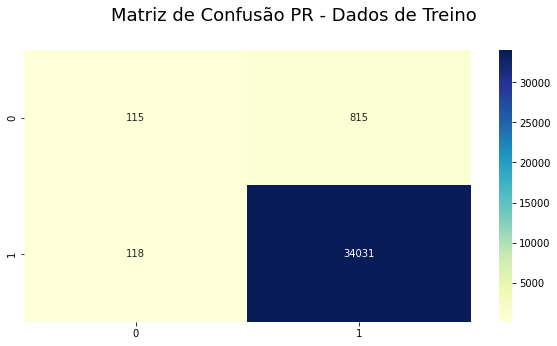



Reporte dos Dados de Teste - PR
              precision    recall  f1-score   support

           0       0.48      0.11      0.18       413
           1       0.98      1.00      0.99     14723

    accuracy                           0.97     15136
   macro avg       0.73      0.55      0.58     15136
weighted avg       0.96      0.97      0.96     15136





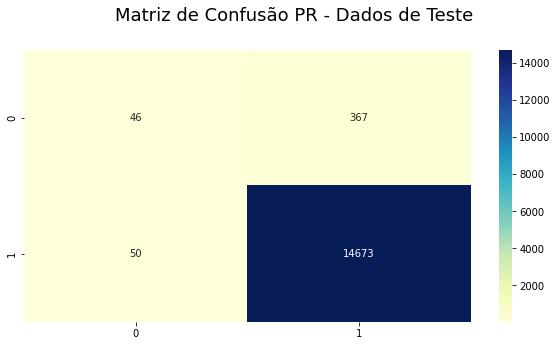

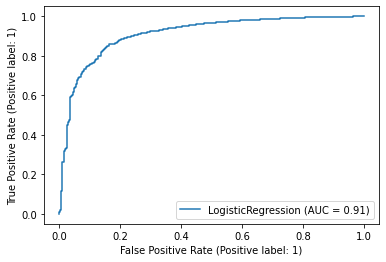

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model.score(xteste,yteste))
  print('\033[1m'+'Intercept:'+'\033[0m',model.intercept_,'\033[1m')
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PR'+'\033[0m')
  print(classification_report(ytreino, model.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PR'+'\033[0m')
  print(classification_report(yteste, model.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model.coef_).T
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [ ]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
183,0.02,v249
188,0.02,v260
153,0.02,v206
85,0.01,v118
154,0.01,v207
...,...,...
31,-0.01,v46
177,-0.01,v243
156,-0.01,v209
35,-0.06,v51


In [ ]:
n=gc.collect()

##Modelo 1: Árvore de Decisão.

In [ ]:
model1 = DecisionTreeClassifier(max_depth=2, random_state=18)

In [ ]:
with parallel_backend('dask'):
  model1.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9791613215884147 R² de teste: 0.9765459830866807
RMSE de Treino: 0.02083867841158528 RMSE de Teste: 0.023454016913319237


Reporte dos Dados de Treino - PR
              precision    recall  f1-score   support

           0       0.67      0.43      0.52       930
           1       0.98      0.99      0.99     34149

    accuracy                           0.98     35079
   macro avg       0.83      0.71      0.76     35079
weighted avg       0.98      0.98      0.98     35079





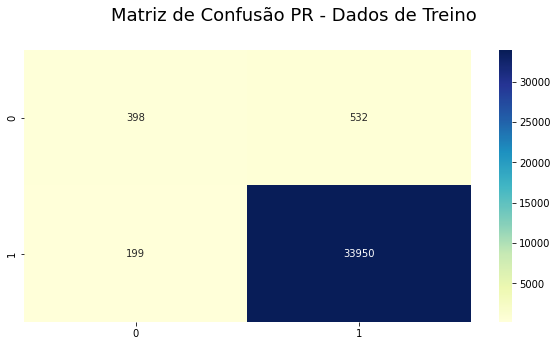



Reporte dos Dados de Teste - PR
              precision    recall  f1-score   support

           0       0.60      0.41      0.49       413
           1       0.98      0.99      0.99     14723

    accuracy                           0.98     15136
   macro avg       0.79      0.70      0.74     15136
weighted avg       0.97      0.98      0.97     15136





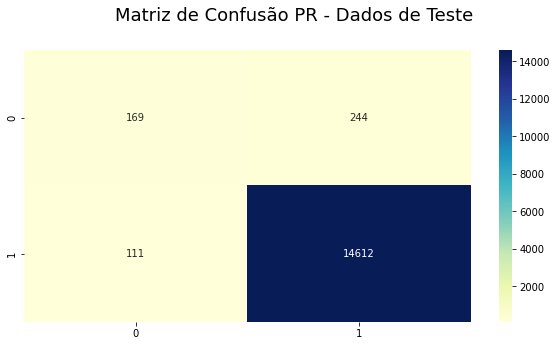

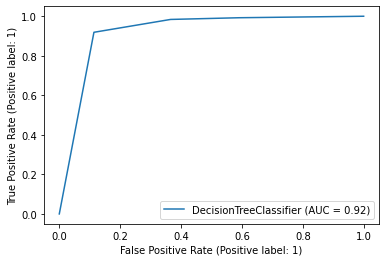

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model1.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model1.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model1.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model1.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PR'+'\033[0m')
  print(classification_report(ytreino, model1.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model1.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PR'+'\033[0m')
  print(classification_report(yteste, model1.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model1.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model1,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model1.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [ ]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
50,0.89,v68
33,0.06,v48
79,0.05,v112
131,0.00,v182
123,0.00,v174
...,...,...
66,0.00,v91
67,0.00,v92
68,0.00,v93
69,0.00,v94


In [ ]:
n=gc.collect()

##Modelo 2: Ada Boost.

In [ ]:
model2 = AdaBoostClassifier(n_estimators=40)

In [ ]:
with parallel_backend('dask'):
  model2.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9766241911114912 R² de teste: 0.9750264270613108
RMSE de Treino: 0.023375808888508796 RMSE de Teste: 0.024973572938689216


Reporte dos Dados de Treino - PR
              precision    recall  f1-score   support

           0       0.60      0.35      0.44       930
           1       0.98      0.99      0.99     34149

    accuracy                           0.98     35079
   macro avg       0.79      0.67      0.71     35079
weighted avg       0.97      0.98      0.97     35079





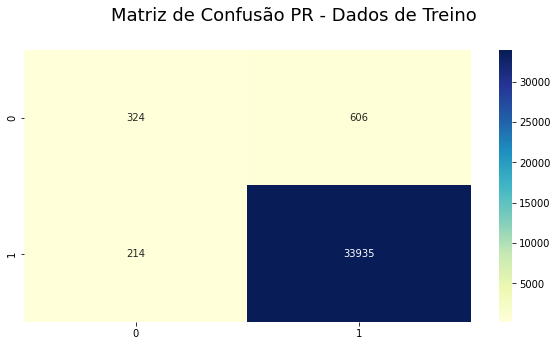



Reporte dos Dados de Teste - PR
              precision    recall  f1-score   support

           0       0.57      0.33      0.42       413
           1       0.98      0.99      0.99     14723

    accuracy                           0.98     15136
   macro avg       0.78      0.66      0.70     15136
weighted avg       0.97      0.98      0.97     15136





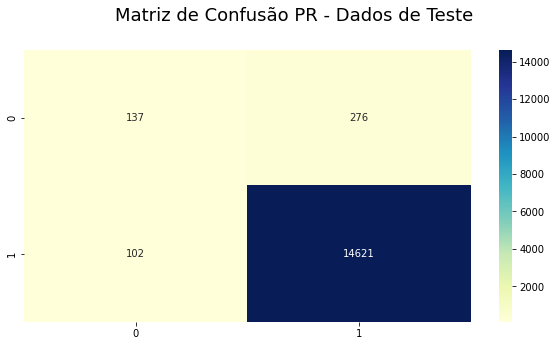

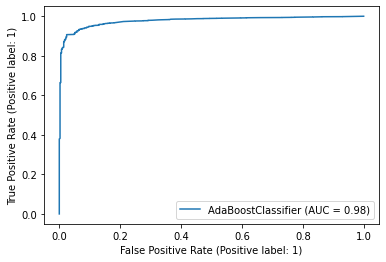

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model2.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model2.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model2.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model2.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PR'+'\033[0m')
  print(classification_report(ytreino, model2.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model2.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PR'+'\033[0m')
  print(classification_report(yteste, model2.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model2.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model2,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model2.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [ ]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
33,0.10,v48
74,0.10,v101
73,0.07,v100
4,0.05,v4
186,0.05,v251
...,...,...
75,0.00,v106
76,0.00,v107
77,0.00,v108
78,0.00,v109


In [ ]:
n=gc.collect()

##Modelo 3: Gradient Boosting.

In [ ]:
model3 = GradientBoostingClassifier(n_estimators=300)

In [ ]:
with parallel_backend('dask'):
  model3.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9922745802331879 R² de teste: 0.983747357293869
RMSE de Treino: 0.007725419766812053 RMSE de Teste: 0.01625264270613108


Reporte dos Dados de Treino - PR
              precision    recall  f1-score   support

           0       0.91      0.79      0.84       930
           1       0.99      1.00      1.00     34149

    accuracy                           0.99     35079
   macro avg       0.95      0.89      0.92     35079
weighted avg       0.99      0.99      0.99     35079





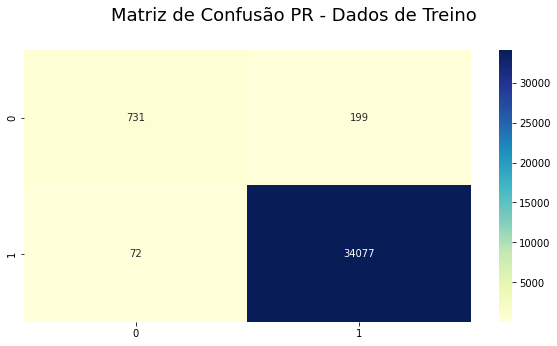



Reporte dos Dados de Teste - PR
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       413
           1       0.99      0.99      0.99     14723

    accuracy                           0.98     15136
   macro avg       0.87      0.80      0.83     15136
weighted avg       0.98      0.98      0.98     15136





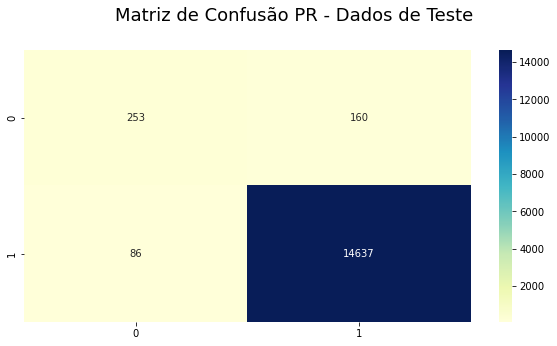

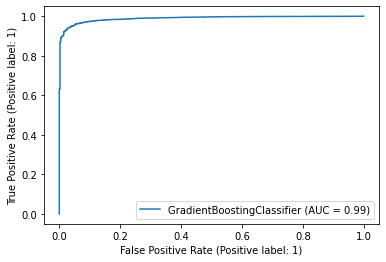

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model3.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model3.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model3.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model3.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PR'+'\033[0m')
  print(classification_report(ytreino, model3.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model3.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PR'+'\033[0m')
  print(classification_report(yteste, model3.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model3.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model3,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model3.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [ ]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
50,0.23,v68
33,0.13,v48
35,0.11,v51
190,0.09,v259
51,0.04,v69
...,...,...
97,0.00,v141
96,0.00,v139
94,0.00,v137
93,0.00,v128


In [ ]:
n=gc.collect()

##Modelo 4: Bagging.

In [ ]:
model4 = BaggingClassifier(n_estimators=1)

In [ ]:
with parallel_backend('dask'):
  model4.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9929302431654267 R² de teste: 0.9774048625792812
RMSE de Treino: 0.007069756834573391 RMSE de Teste: 0.022595137420718815


Reporte dos Dados de Treino - PR
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       930
           1       1.00      1.00      1.00     34149

    accuracy                           0.99     35079
   macro avg       0.93      0.93      0.93     35079
weighted avg       0.99      0.99      0.99     35079





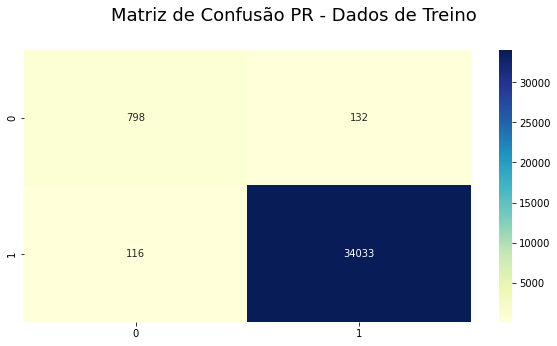



Reporte dos Dados de Teste - PR
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       413
           1       0.99      0.99      0.99     14723

    accuracy                           0.98     15136
   macro avg       0.79      0.79      0.79     15136
weighted avg       0.98      0.98      0.98     15136





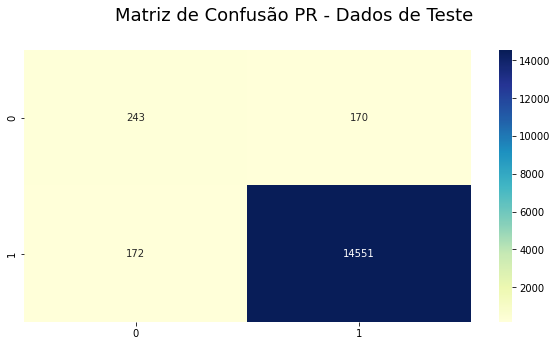

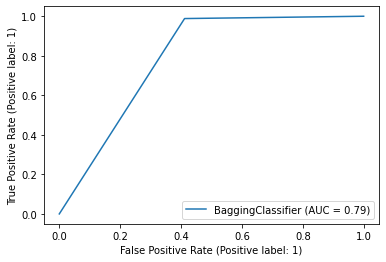

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model4.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model4.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model4.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model4.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PR'+'\033[0m')
  print(classification_report(ytreino, model4.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model4.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PR'+'\033[0m')
  print(classification_report(yteste, model4.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model4.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model4,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
n=gc.collect()

##Modelo 5: Random Forrest.

In [ ]:
model5 = RandomForestClassifier(n_estimators=2)

In [ ]:
with parallel_backend('dask'):
  model5.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9906496764445964 R² de teste: 0.9707320295983086
RMSE de Treino: 0.009350323555403517 RMSE de Teste: 0.02926797040169133


Reporte dos Dados de Treino - PR
              precision    recall  f1-score   support

           0       0.75      0.97      0.85       930
           1       1.00      0.99      1.00     34149

    accuracy                           0.99     35079
   macro avg       0.88      0.98      0.92     35079
weighted avg       0.99      0.99      0.99     35079





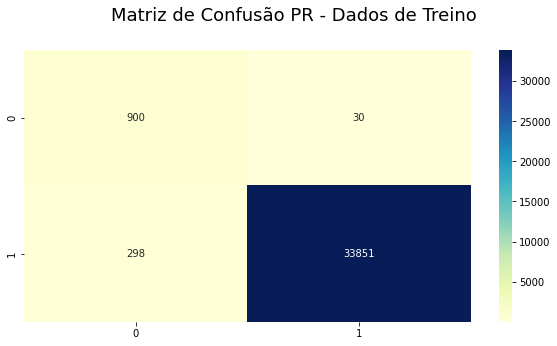



Reporte dos Dados de Teste - PR
              precision    recall  f1-score   support

           0       0.48      0.77      0.59       413
           1       0.99      0.98      0.98     14723

    accuracy                           0.97     15136
   macro avg       0.74      0.87      0.79     15136
weighted avg       0.98      0.97      0.97     15136





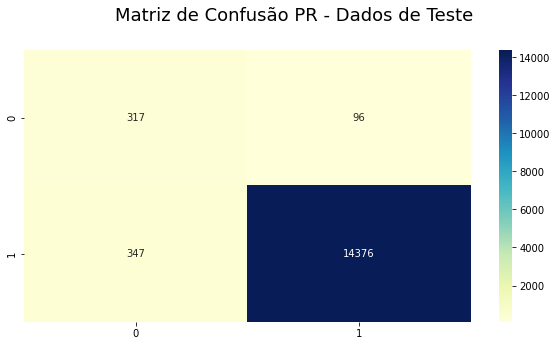

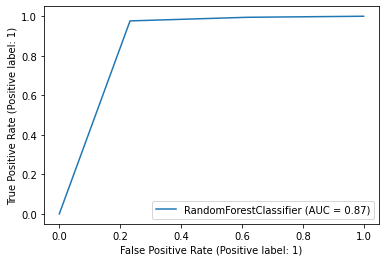

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model5.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model5.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model5.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model5.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PR'+'\033[0m')
  print(classification_report(ytreino, model5.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model5.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PR'+'\033[0m')
  print(classification_report(yteste, model5.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model5.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model5,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model5.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [ ]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
190,0.23,v259
35,0.06,v51
33,0.04,v48
18,0.02,v21
34,0.02,v50
...,...,...
97,0.00,v141
96,0.00,v139
94,0.00,v137
93,0.00,v128


In [ ]:
n=gc.collect()

##Modelo 6: Suport Vector Machine (kernel rbf).

In [ ]:
model6 = SVC(C=30000)

In [ ]:
with parallel_backend('dask'):
  model6.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9734884118703497 R² de teste: 0.9727140591966174
RMSE de Treino: 0.026511588129650217 RMSE de Teste: 0.027285940803382664


Reporte dos Dados de Treino - PR


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       930
           1       0.97      1.00      0.99     34149

    accuracy                           0.97     35079
   macro avg       0.49      0.50      0.49     35079
weighted avg       0.95      0.97      0.96     35079





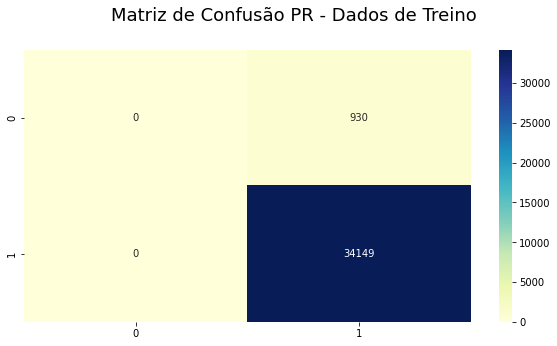



Reporte dos Dados de Teste - PR


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       413
           1       0.97      1.00      0.99     14723

    accuracy                           0.97     15136
   macro avg       0.49      0.50      0.49     15136
weighted avg       0.95      0.97      0.96     15136





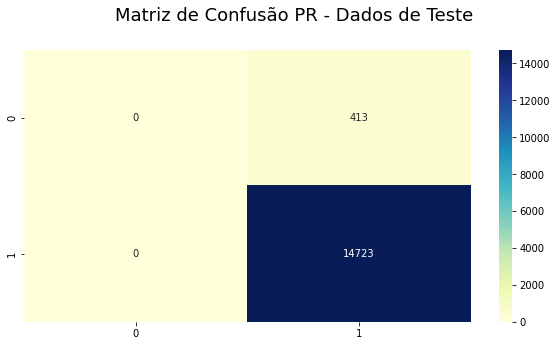

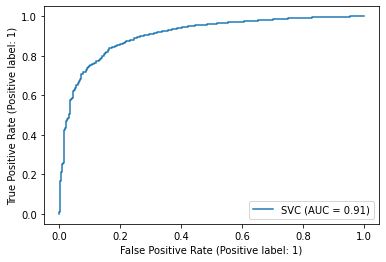

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model6.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model6.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model6.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model6.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PR'+'\033[0m')
  print(classification_report(ytreino, model6.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model6.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PR'+'\033[0m')
  print(classification_report(yteste, model6.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model6.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model6,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
n=gc.collect()

##Modelo 7: KNN.

In [ ]:
model7 = KNeighborsClassifier(n_neighbors=3)

In [ ]:
with parallel_backend('dask'):
  model7.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9794748995125289 R² de teste: 0.9711945031712473
RMSE de Treino: 0.020525100487471137 RMSE de Teste: 0.028805496828752643


Reporte dos Dados de Treino - PR
              precision    recall  f1-score   support

           0       0.79      0.31      0.44       930
           1       0.98      1.00      0.99     34149

    accuracy                           0.98     35079
   macro avg       0.89      0.65      0.72     35079
weighted avg       0.98      0.98      0.98     35079





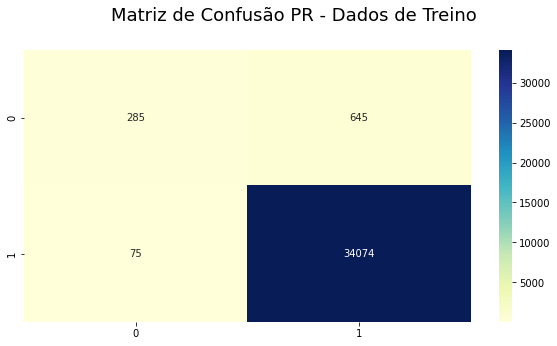



Reporte dos Dados de Teste - PR
              precision    recall  f1-score   support

           0       0.42      0.16      0.23       413
           1       0.98      0.99      0.99     14723

    accuracy                           0.97     15136
   macro avg       0.70      0.58      0.61     15136
weighted avg       0.96      0.97      0.96     15136





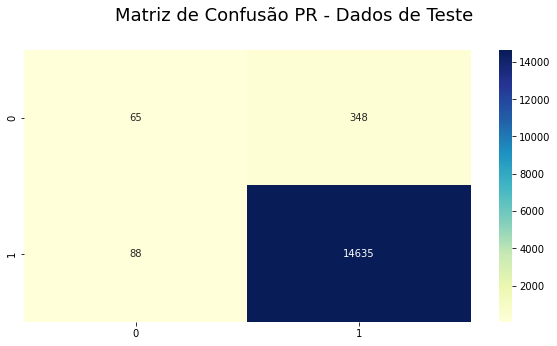

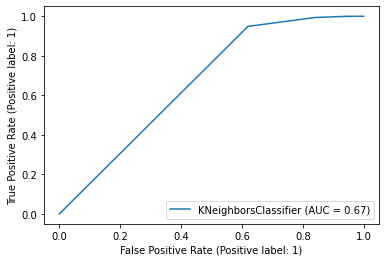

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model7.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model7.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model7.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model7.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PR'+'\033[0m')
  print(classification_report(ytreino, model7.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model7.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PR'+'\033[0m')
  print(classification_report(yteste, model7.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model7.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PR - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model7,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
n=gc.collect()

##Consolidação das Curvas ROC

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

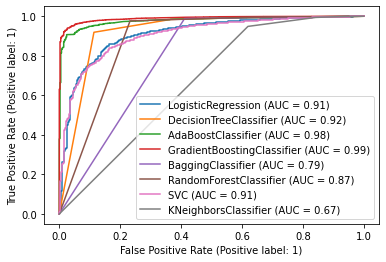

In [ ]:
with parallel_backend('dask'):
  classifiers = [model, model1, model2, model3, model4, model5, model6, model7]
  ax = plt.gca()
  for i in classifiers:
      metrics.plot_roc_curve(i, xteste, yteste, ax=ax)